In [4]:
import numpy as np
import pandas as pd
from pathlib import Path 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import trapezoid 

In [5]:
def parse_parameters(file_path):
    """
    Читает файл parameters.txt и возвращает словарь с нужными параметрами
    """
    params = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) >= 2:
                key = parts[0]
                value = ' '.join(parts[1:])  # на случай, если значение содержит пробелы
                params[key] = value
    # Извлекаем нужные параметры
    result = {}
    for param in ['Msw', 'XUVInt', 'H2a', 'Helium']:
        result[param] = params.get(param)
    return result

def process_files_in_folder_with_params(root_folder):
    """
    Рекурсивно проходит по папке, читает параметры и файлы с данными
    Возвращает список словарей, где каждый словарь — это один файл
    """
    dataset = []
    root = Path(root_folder)
    for data_file_path in root.rglob('*[.txt,.dat]'):
        if data_file_path.name == 'parameters.txt':
            continue  # Пропускаем файл параметров

        # Ищем файл parameters.txt в той же папке
        param_file_path = data_file_path.parent / 'parameters.txt'

        if param_file_path.exists():
            params = parse_parameters(param_file_path)
            # print(f"Файл: {data_file_path}")
            # print(f"Параметры: {params}")
        else:
            # print(f"Файл parameters.txt не найден для {data_file_path}")
            params = {}

        # Читаем V и FullAbs из data файла
        try:
            V, FullAbs = np.loadtxt(data_file_path, usecols=(0, 1), unpack=True, skiprows=1)
            entry = {
                'V': V,
                'FullAbs': FullAbs,
                'Msw': params.get('Msw'),
                'XUVInt': params.get('XUVInt'),
                'H2a': params.get('H2a'),
                'Helium': params.get('Helium'),
                'File': str(data_file_path)  # можно убрать, если не нужно
            }
            dataset.append(entry)
        except Exception as e:
            print(f"Ошибка при загрузке данных из {data_file_path}: {e}")
        # print("-" * 50)

    return dataset



In [6]:
def find_fwhm(V, FullAbs):
    """
    Находит FWHM (Full Width at Half Maximum) для заданной кривой V vs FullAbs
    """
    if len(V) == 0 or len(FullAbs) == 0:
        return np.nan, np.nan, np.nan

    max_idx = np.argmax(FullAbs)
    peak_V = V[max_idx]
    peak_FullAbs = FullAbs[max_idx]

    half_max = peak_FullAbs / 2.0

    # Находим левую и правую точки на уровне half_max
    left_idx = np.where(FullAbs[:max_idx] <= half_max)[0]
    right_idx = np.where(FullAbs[max_idx:] <= half_max)[0]

    if len(left_idx) == 0 or len(right_idx) == 0:
        return peak_V, peak_FullAbs, np.nan  # Не удалось найти FWHM

    left_idx = left_idx[-1] if len(left_idx) > 0 else 0
    right_idx = right_idx[0] + max_idx if len(right_idx) > 0 else len(V) - 1

    fwhm = V[right_idx] - V[left_idx]

    return peak_V, peak_FullAbs, fwhm


def compute_analysis(dataset):
    """
    Добавляет к каждому элементу словаря аналитические параметры: peak_V, peak_FullAbs, fwhm
    """
    for entry in dataset:
        peak_V, peak_FullAbs, fwhm = find_fwhm(entry['V'], entry['FullAbs'])
        fullAbs, v =  entry['FullAbs'], entry['V']
        entry['peak_V'] = peak_V
        entry['peak_FullAbs'] = peak_FullAbs
        entry['fwhm'] = fwhm
        area = trapezoid(fullAbs, v)
        entry['area'] = area

    return dataset

In [7]:
# Пример использования:
folder_path = 'dataset'  # Укажите путь к вашей папке
dataset = process_files_in_folder_with_params(folder_path)

dataset = compute_analysis(dataset)

In [8]:
dataset

[{'V': array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
         -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9,
         -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8,
         -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7,
         -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,
          0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
          1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,
          2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
          3.8,  3.9,  4. ]),
  'FullAbs': array([5.06662e-05, 1.03927e-04, 1.41210e-04, 1.90025e-04, 2.53660e-04,
         3.35966e-04, 4.40836e-04, 5.71427e-04, 7.29096e-04, 9.12232e-04,
         1.11527e-03, 1.32825e-03, 1.53720e-03, 1.72550e-03, 1.87607e-03,
         1.97396e-03, 2.00890e-03, 1.97714e-03, 1.88221e-03, 1.73429e-03,
         1.54834e-03, 1.34154e-03, 1.13071e-03, 9.30033e-04

In [29]:
def plot_analysis(dataset, metrics = ['fwhm', 'peak_V', 'peak_FullAbs', 'area'], params = ['Msw_normalized', 'XUVInt', 'H2a', 'Helium'] ):

    df = pd.DataFrame(dataset)
    
    for param in ['Msw', 'XUVInt', 'H2a', 'Helium']:
        df[param] = pd.to_numeric(df[param], errors='coerce')
    scaler = MinMaxScaler()
    df['Msw_normalized'] = scaler.fit_transform(df[['Msw']].fillna(0))
    
    x_vars = metrics
    y_vars = params

    fig, axes = plt.subplots(len(y_vars), len(x_vars), figsize=(15, 12), squeeze=False)
    for i, y_var in enumerate(y_vars):
        for j, x_var in enumerate(x_vars):
            sns.scatterplot(data=df, x=x_var, y=y_var, ax=axes[i][j], hue="H2a")
            axes[i][j].set_title(f'{y_var} vs {x_var}')
            axes[i][j].set_box_aspect(1)
    plt.tight_layout() 
    plt.show()

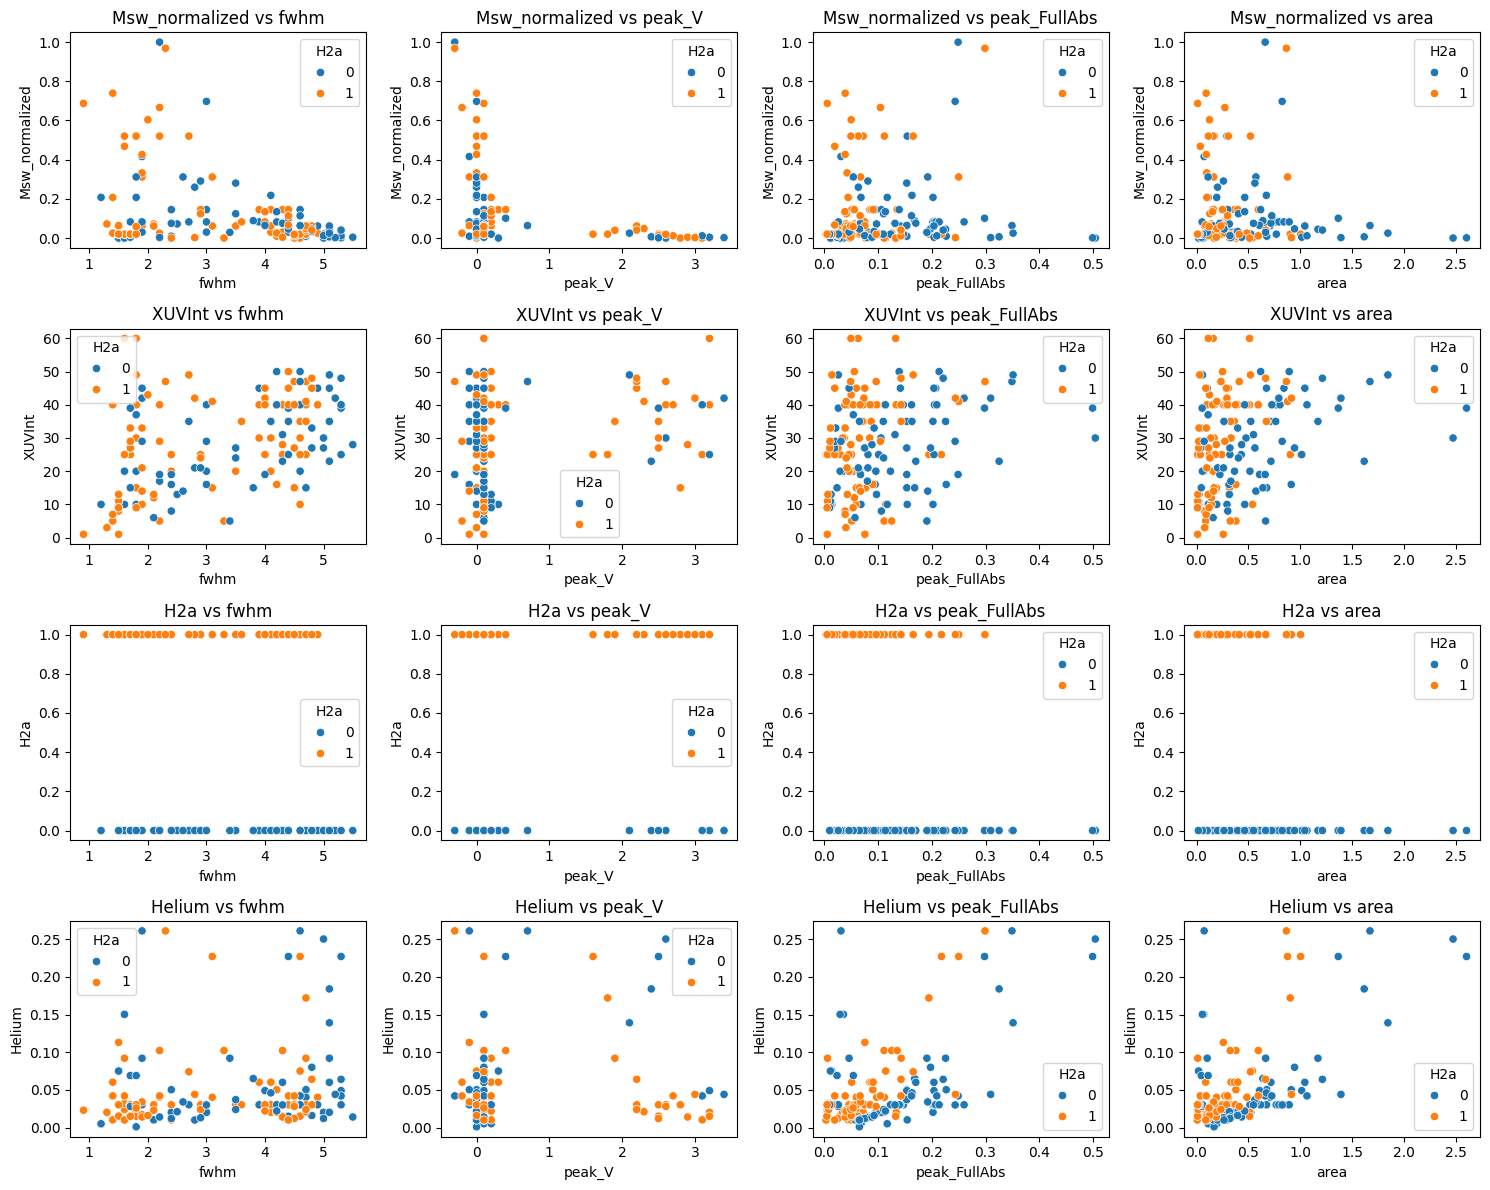

In [24]:
plot_analysis(dataset)

In [18]:
def plot_regression_and_correlation(dataset, output_dir='plots', params = ['Msw', 'XUVInt', 'H2a', 'Helium'], metrics = ['fwhm', 'peak_V', 'peak_FullAbs', 'area'] ):
    # Собираем данные
    df = pd.DataFrame(dataset)

    for param in params:
        df[param] = pd.to_numeric(df[param], errors='coerce')
    
    fig, axes = plt.subplots(len(y_vars), len(x_vars), figsize=(15, 12))
    for i, metric in enumerate(metrics):
        for j, param in enumerate(params):
            x = df[param].dropna()
            y = df[metric].dropna()
            # Выравниваем по индексам
            df_aligned = pd.concat([x, y], axis=1).dropna()
            if df_aligned.empty:
                continue

            x_aligned = df_aligned[param]
            y_aligned = df_aligned[metric]

            # Корреляция Пирсона
            r, p = pearsonr(x_aligned, y_aligned)

            # Построение графика с линией регрессии
            sns.regplot(x=param, y=metric, data=df_aligned)
            axes[i][j].title(f'{metric} vs {param}\n(r = {r:.3f}, p = {p:.3e})')

            # Сохранение графика
            file_name = f"{metric}_vs_{param}_regression.png"
            file_path = Path(output_dir) / file_name
            plt.tight_layout()
            plt.close()

In [13]:
# Пример использования:
folder_path_test_xuv_h1 = 'dataset_testxuvh1'  
dataset_xuvh1 = process_files_in_folder_with_params(folder_path_test_xuv_h1)
dataset_xuvh1 = compute_analysis(dataset_xuvh1)

folder_path_test_xuv_h0 = "dataset_testxuvh0"
dataset_xuvh0 = process_files_in_folder_with_params(folder_path_test_xuv_h0)
dataset_xuvh0 = compute_analysis(dataset_xuvh0)

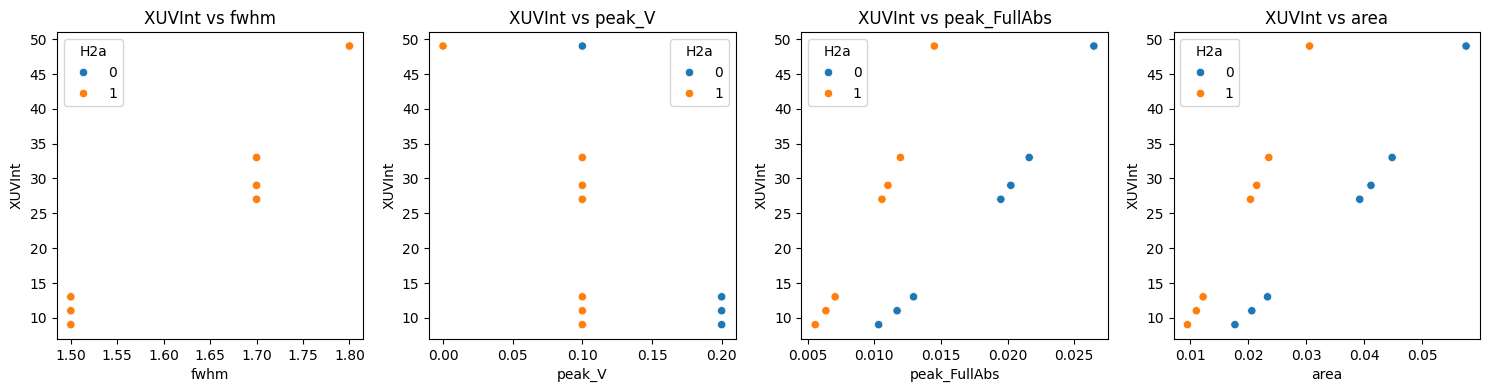

In [30]:
dataset_text_xuv_combined = dataset_xuvh0 + dataset_xuvh1

plot_analysis(dataset_text_xuv_combined, params=['XUVInt'])

In [33]:
df = pd.DataFrame(dataset_text_xuv_combined)
df.head()

,V,FullAbs,Msw,XUVInt,H2a,Helium,File,peak_V,peak_FullAbs,fwhm,area
0,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[5.46492e-05, 7.44289e-05, 0.000101141, 0.0001...",2e12,11,0,0.03022,dataset_testxuvh0/XUV11Msw2e12He0p030198H0/Abs...,0.2,0.011708,1.5,0.020588
1,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[6.64529e-05, 8.97683e-05, 0.000121008, 0.0001...",2e12,13,0,0.03022,dataset_testxuvh0/XUV13Msw2e12He0p030198H0/Abs...,0.2,0.012943,1.5,0.023298
2,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0.00015143, 0.00019815, 0.000258956, 0.000338...",2e12,27,0,0.03022,dataset_testxuvh0/XUV27Msw2e12He0p030198H0/Abs...,0.1,0.019493,1.7,0.039199
3,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0.000163489, 0.00021338, 0.000278163, 0.00036...",2e12,29,0,0.03022,dataset_testxuvh0/XUV29Msw2e12He0p030198H0/Abs...,0.1,0.020241,1.7,0.041138
4,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0.000187278, 0.00024335, 0.000315879, 0.00040...",2e12,33,0,0.03022,dataset_testxuvh0/XUV33Msw2e12He0p030198H0/Abs...,0.1,0.021618,1.7,0.044785
